In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 5.5MB 11.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=96ac11d8f8426119c9ed5eb711b95891b54fc03f5828a927f3388d28fe207570
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
trend = pd.read_csv('google_trend.csv')
trend.head

<bound method NDFrame.head of            Date  Trend
0      1/1/2020     25
1      2/1/2020     26
2      3/1/2020     27
3      4/1/2020     27
4      5/1/2020     27
..          ...    ...
357  27/12/2020     92
358  28/12/2020     74
359  29/12/2020     66
360  30/12/2020     75
361  31/12/2020     75

[362 rows x 2 columns]>

In [3]:
df = yf.download(tickers="BTC-USD",
                start="2020-01-01",
                end="2020-12-31",
                interval="1d")

df = df.reset_index()
price_trend = pd.concat([df[['Open', 'Close', 'Adj Close']], trend['Trend']], axis=1)

num_features = 4
num_train = 310
num_test = 52

training_set = price_trend.iloc[:num_train].values
test_set = price_trend.iloc[:num_train].values

df.head

[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.head of           Date          Open  ...     Adj Close       Volume
0   2020-01-01   7194.892090  ...   7200.174316  18565664997
1   2020-01-02   7202.551270  ...   6985.470215  20802083465
2   2020-01-03   6984.428711  ...   7344.884277  28111481032
3   2020-01-04   7345.375488  ...   7410.656738  18444271275
4   2020-01-05   7410.451660  ...   7411.317383  19725074095
..         ...           ...  ...           ...          ...
357 2020-12-27  26439.373047  ...  26272.294922  66479895605
358 2020-12-28  26280.822266  ...  27084.808594  49056742893
359 2020-12-29  27081.810547  ...  27362.437500  45265946774
360 2020-12-30  27360.089844  ...  28840.953125  51287442704
361 2020-12-31  28841.574219  ...  29001.720703  46754964848

[362 rows x 7 columns]>

In [4]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, num_train):
    X_train.append(training_set_scaled[i-60:i, 0:num_features])
    y_train.append(training_set_scaled[i, 1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

In [5]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50, input_shape = (X_train.shape[1], num_features))))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

In [6]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 8)
model.summary()

Epoch 1/100
32/32 [==============================] - 9s 7ms/step - loss: 0.0415
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0076
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 8/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 9/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 10/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 11/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 12/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 13/100
32/32 [=================

In [7]:
# Getting the predicted stock price
dataset_train = price_trend.iloc[:num_train]
dataset_test = price_trend.iloc[num_train:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,num_features)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, num_test+60):
    X_test.append(inputs[i-60:i, 0:num_features])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

In [8]:
predicted_stock_price = model.predict(X_test)
predicted_padded = np.zeros(shape=(len(predicted_stock_price), num_features))
predicted_padded[:,1] = predicted_stock_price[:,0]
predicted_padded = sc.inverse_transform(predicted_padded)

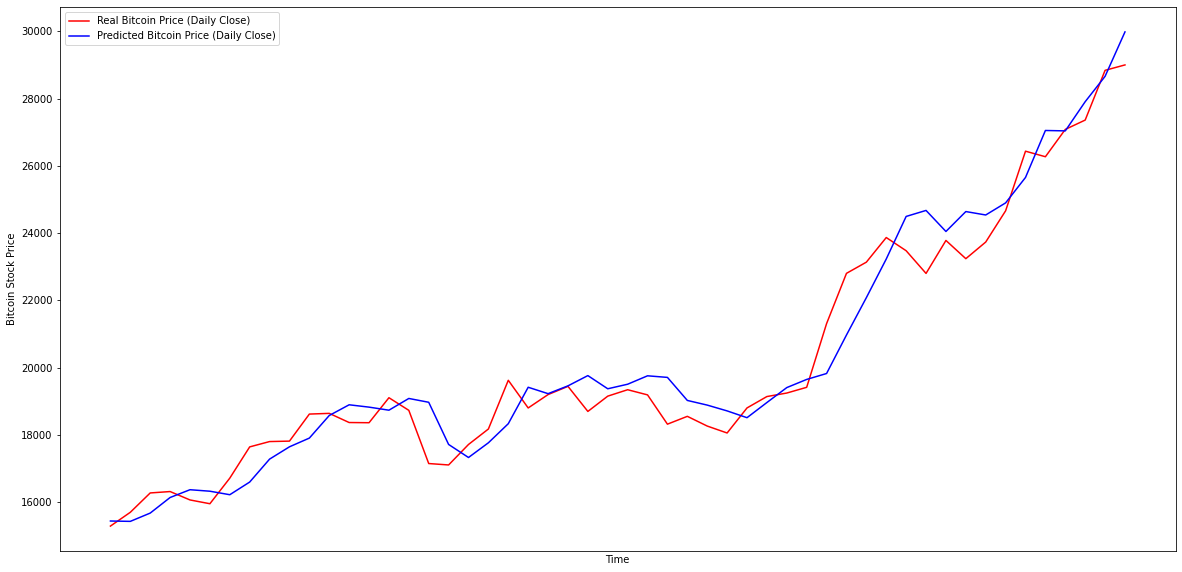

In [9]:
plt.figure(figsize=(20,10))
# Visualising the results
plt.plot(df.loc[num_train:, 'Date'].apply(lambda x: x.strftime('%Y-%m-%d')), df.iloc[num_train:, 4:5], color='red', label = 'Real Bitcoin Price (Daily Close)')
plt.plot(df.loc[num_train:, 'Date'].apply(lambda x: x.strftime('%Y-%m-%d')), predicted_padded[:,1], color = 'blue', label = 'Predicted Bitcoin Price (Daily Close)')

plt.title('')
plt.xlabel('Time')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylabel('Bitcoin Stock Price')
plt.legend()
plt.show()

In [11]:
error_sum = 0

for i in range(len(predicted_padded)):
    diff = abs(predicted_padded[i,1] - df.loc[num_train+i, 'Close']) / df.loc[num_train+i, 'Close']
    error_sum += diff

error_avg = error_sum / len(predicted_padded)
acc = 1 - error_avg
print(acc)

0.9697603428148551


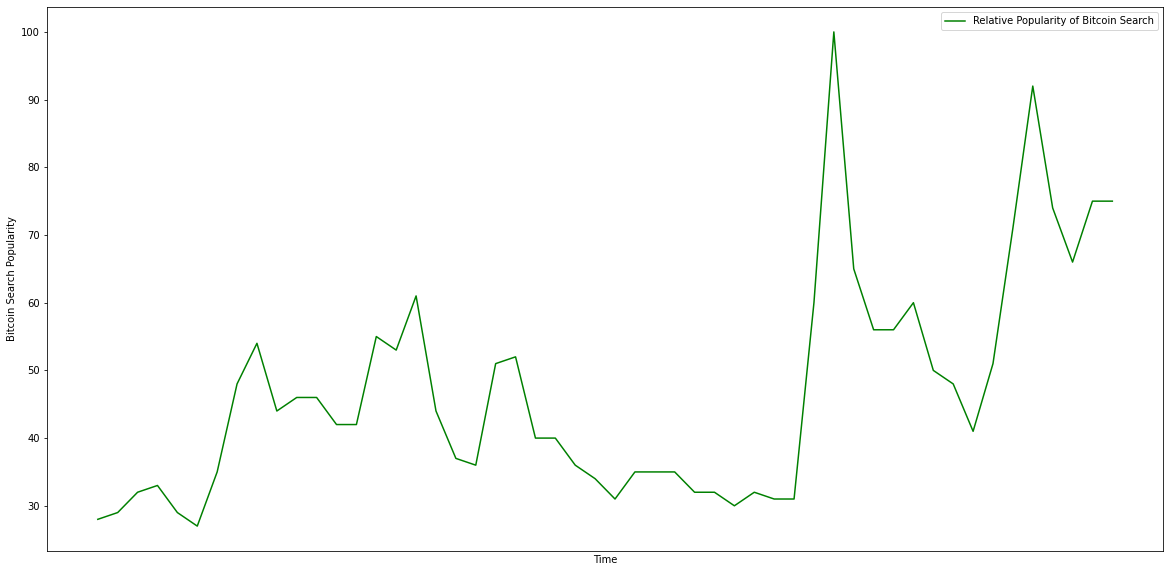

In [10]:
# Google Trends plot
plt.figure(figsize=(20,10))
# Visualising the results
plt.plot(df.loc[num_train:, 'Date'].apply(lambda x: x.strftime('%Y-%m-%d')), trend.iloc[num_train:, 1:2], color='green', label = 'Relative Popularity of Bitcoin Search')

plt.xlabel('Time')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylabel('Bitcoin Search Popularity')
plt.legend()
plt.show()